# Aggregating dataset

In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
og_predictors = np.loadtxt('./Data/predictors_fl.csv', delimiter=',', dtype='object')
og_freshly_browsed = np.loadtxt('./Data/freshly_browsed_fl.csv', delimiter=',', dtype='object')

print('Shape of predictors:', np.shape(og_predictors))
print('Shape of target values:', np.shape(og_freshly_browsed))

Shape of predictors: (2101, 81)
Shape of target values: (2101, 27)


In [3]:
agg_predictors = og_predictors.copy()

agg_predictors[1:, :] = agg_predictors[1:, :].astype(float)

rows, cols = np.shape(og_predictors)

for i in range(1, rows):
    for j in range(0, cols, 3):
        start_row = max(i - 2, int((i // 100 * 100 + 1)))
        end_row = min(i + 2, int((i // 100 + 1) * 100 - 1))

        agg_predictors[i, j] = np.sum(og_predictors[start_row:end_row+1, j].astype(float))

In [4]:
noSupply_value = -0.00001

agg_freshly_browsed = og_freshly_browsed.copy()

agg_freshly_browsed[1:, :] = agg_freshly_browsed[1:, :].astype(float)

rows, cols = np.shape(og_freshly_browsed)

for i in range(1, rows):
    for j in range(0, cols):
        # Choosing 5 adjacent points within the limit of one forest.
        start_row = max(i - 2, int((i // 100 * 100) + 1))  
        end_row = min(i + 2, int((i // 100 + 1) * 100 - 1))

        aggregated_supply = np.sum(og_predictors[start_row:end_row+1, j * 3].astype(float))

        if aggregated_supply > 0:
            aggregated_browsed = sum([(float(og_predictors[row,j*3]) / float(aggregated_supply)) * float(og_freshly_browsed[row,j]) \
                for row in range(start_row, end_row+1)])

            agg_freshly_browsed[i,j] = aggregated_browsed

        else:
            agg_freshly_browsed[i, j] = noSupply_value

In [5]:
print('Shape of aggregated predictors:', np.shape(agg_predictors))
print('Shape of aggregated target values:', np.shape(agg_freshly_browsed))

Shape of aggregated predictors: (2101, 81)
Shape of aggregated target values: (2101, 27)


In [6]:
np.savetxt('./Data/agg_predictors_fl.csv', agg_predictors, fmt='%s', delimiter=',')
np.savetxt('./Data/agg_freshly_browsed_dist_fl.csv', agg_freshly_browsed, fmt='%s', delimiter=',')

## Inspecting aggregated dataset

In [7]:
# Saving shapes of data:
rows, cols_X = np.shape(agg_predictors)
cols_y = np.shape(agg_freshly_browsed)[1]

# Saving species names:
species = [' '.join(sp.split(' ')[:-2]) for sp in agg_freshly_browsed[0, :]]

print(species)

['Unknown', 'Quercus petraea', 'Quercus cerris', 'Fraxinus excelsior', 'Fraxinus ornus', 'Carpinus betulus', 'Fagus sylvatica', 'Acer pseudoplatanus', 'Acer platanoides', 'Acer campestre', 'Pinus sylvestris', 'Robinia pseudoacacia', 'Ligustrum vulgare ', 'Crataegus monogyna', 'Cornus mas', 'Cornus sanguinea', 'Prunus spinosa', 'Rubus fruticosus ', 'Rosa canina ', 'Acer tataricum', 'Prunus avium ', 'Corylus avellana', 'Ulmus minor ', 'Sorbus aucuparia', 'Pyrus pyraster ', 'Euonymus verrucosus', 'Quercus pubescens']


In [20]:
all_shoots = agg_predictors[:,[i for i in range(cols_X) if i % 3 == 0]]
frequency = agg_predictors[:,[i for i in range(cols_X) if i % 3 == 1]]
rps = agg_predictors[:,[i for i in range(cols_X) if i % 3 == 2]]

/var/folders/t3/fn5x2gps4wq728lxf9qrv_lm0000gn/T/ipykernel_26215/1851984926.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


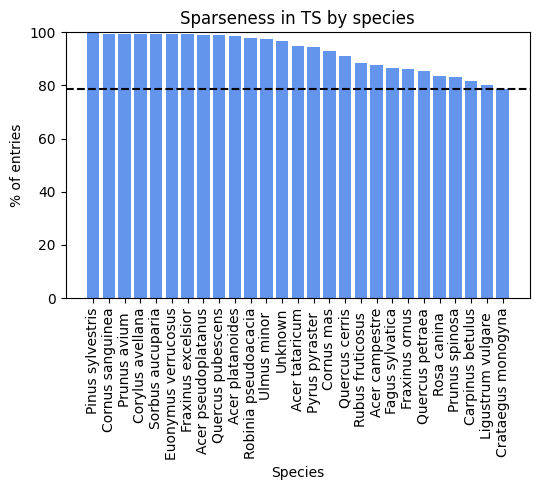

<Figure size 640x480 with 0 Axes>

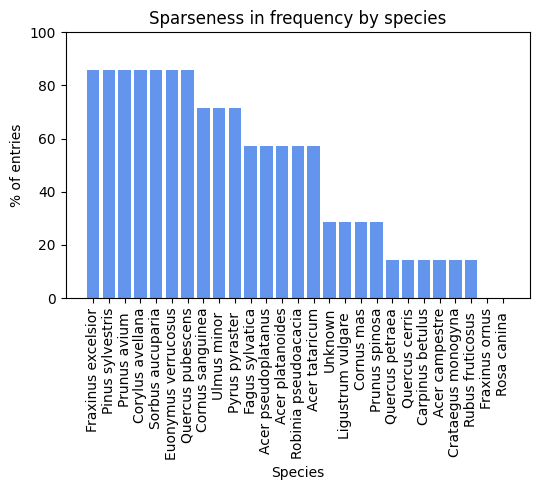

<Figure size 640x480 with 0 Axes>

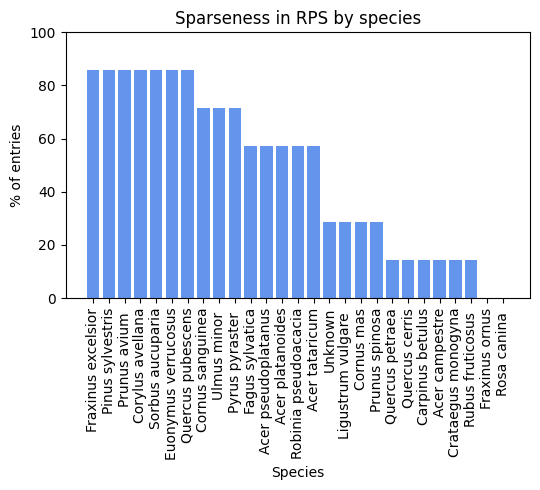

<Figure size 640x480 with 0 Axes>

In [21]:
features = [all_shoots, frequency, rps]
feature_names = ['TS', 'frequency', 'RPS']

for i, feature in enumerate(features):
    # Collecting proportion of 0 values for each species in a list.
    zeros = [np.count_nonzero(feature[1:,i] == 0) / rows for i in range(np.shape(feature)[1])]

    # Creating a sorted dictionary which stores the proportion of 0 values for each species.
    zeroDict = {key : value for key, value in \
                sorted({sp : zeroes for sp, zeroes in zip(species, zeros)}.items(), \
                       key=lambda item: item[1], reverse=True)}
    
    labels = list(zeroDict.keys())
    values = [i * 100 for i in list(zeroDict.values())]

    # Saving species which are not present at all:
    if feature_names[i] == 'shoots offered':
        not_present = [labels[i] for i, value in enumerate(values) if value == 100]

    fig, ax = plt.subplots(figsize=(5.5,5))
    
    ax.bar(labels, values, color=['orange' if value == 100 else 'cornflowerblue' for value in values])

    ax.set_xlabel('Species')
    ax.set_ylabel('% of entries')
    ax.set_title(f'Sparseness in {feature_names[i]} by species')

    if min(values) > 90.0:
        plt.ylim(90, 100)
    
    else:
        plt.ylim(0, 100)
    
    ax.set_xticklabels(labels, rotation=90)

    if min(values) > 0.0:
        plt.axhline(y=min(values), color='black', linestyle='--')

    plt.tight_layout()

    file_name = '_'.join(feature_names[i].split(' ')[:2]) 

    plt.savefig(f'./Figures/agg_sparseness_{file_name}')

    plt.show()

    plt.clf()

[99.47643979057592, 99.47643979057592, 99.47643979057592, 99.23845787720134, 99.09566872917658, 98.66730128510233, 99.71442170395049, 97.85816277962874, 98.857686815802, 91.05188005711567, 99.19086149452642, 99.23845787720134, 96.6206568300809, 97.52498810090432, 88.33888624464541, 93.09852451213708, 95.00237981913374, 85.43550690147549, 94.5740123750595, 87.7201332698715, 86.72060923369824, 86.19704902427415, 83.38886244645407, 83.1984769157544, 78.72441694431224, 81.67539267015707, 80.10471204188482]
[0.47596382674916704, 0.47596382674916704, 0.47596382674916704, 0.7139457401237506, 0.8567348881485007, 1.285102332222751, 0.23798191337458352, 2.094240837696335, 0.9519276534983341, 8.66254164683484, 0.5235602094240838, 0.47596382674916704, 2.6178010471204187, 1.475487862922418, 10.423607805806759, 5.330794859590672, 3.426939552594003, 12.613041408852926, 3.4745359352689196, 9.99524036173251, 10.804378867206092, 10.280818657782008, 12.375059495478343, 12.517848643503093, 16.658733936220

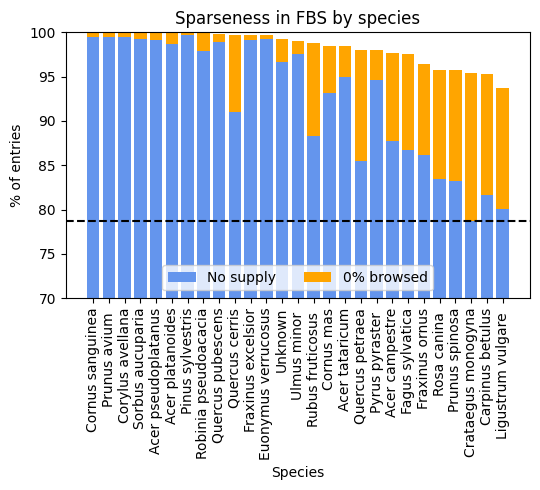

In [22]:
# Showing sparseness with distinction between 0 supply and 0% browsed for the target variable.
negatives = [np.count_nonzero(agg_freshly_browsed[1:,i] < 0) / rows * 100 for i in range(np.shape(agg_freshly_browsed)[1])]
zeros = [np.count_nonzero(agg_freshly_browsed[1:,i] == 0) / rows * 100 for i in range(np.shape(agg_freshly_browsed)[1])]
summed = [negatives[i] + zeros[i] for i in range(len(negatives))]

sorted_Dict = {key : value for key, value in \
                sorted({sp : sum for sp, sum in zip(species, summed)}.items(), \
                       key=lambda item: item[1], reverse=True)}

labels = list(sorted_Dict.keys())

sorted_negatives = []
sorted_zeros = []

for sp in labels:
    index = species.index(sp)

    sorted_negatives.append(negatives[index])
    sorted_zeros.append(zeros[index])

print(sorted_negatives)
print(sorted_zeros)

x = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(5.5,5))

ax.bar(x, sorted_negatives, label='No supply', color='cornflowerblue')
ax.bar(x, sorted_zeros, bottom=sorted_negatives, label='0% browsed', color='orange')

# Set labels and title
ax.set_xlabel('Species')
ax.set_ylabel('% of entries')
ax.set_title('Sparseness in FBS by species')

# Set x-axis tick labels
ax.set_xticks(x, labels, rotation=90)

# Add legend
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 0.15), ncol=2)

plt.ylim(70, 100)

plt.axhline(y=min(negatives), color='black', linestyle='--')

plt.tight_layout()

plt.savefig(f'./Figures/agg_sparseness_freshly_browsed')

# Show the plot
plt.show()

99.95240361732507


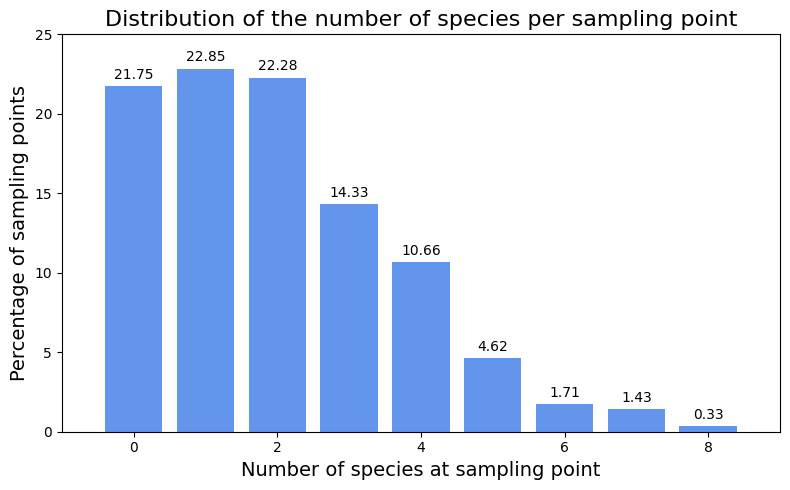

In [23]:
nr_species_perPoint = np.count_nonzero(all_shoots, axis=1)

hist_values, bin_edges = np.histogram(nr_species_perPoint, bins=np.arange(0, np.max(nr_species_perPoint) + 2))

hist_values = hist_values / rows * 100      # Turning frequencies into percentages.

fig, ax = plt.subplots(figsize=(8,5))

bars = ax.bar(bin_edges[:11], hist_values[:11], align='center', width=0.8, color='cornflowerblue')

for bar, value in zip(bars, hist_values[:11]):
    if value > 0:
        height = bar.get_height()
        ax.annotate(f'{value:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
                    textcoords='offset points', ha='center', va='bottom')

#ax.bar_label(plt.bar(bin_edges[:11], hist_values[:11], align='center', width=0.8, color='cornflowerblue'), fmt='%.2f')

print(sum(hist_values[:11]))

ax.set_xlim((-1,9))
ax.set_ylim((0, 25))

ax.set_xlabel('Number of species at sampling point', fontsize=14)
ax.set_ylabel('Percentage of sampling points', fontsize=14)
ax.set_title('Distribution of the number of species per sampling point', fontsize=16)

plt.tight_layout()

plt.savefig(f'./Figures/agg_nr_species_distribution.png')

plt.show()

## Displaying means and standard deviations

/var/folders/t3/fn5x2gps4wq728lxf9qrv_lm0000gn/T/ipykernel_26215/2855970591.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(labels1, rotation=90)
/var/folders/t3/fn5x2gps4wq728lxf9qrv_lm0000gn/T/ipykernel_26215/2855970591.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(labels2, rotation=90)


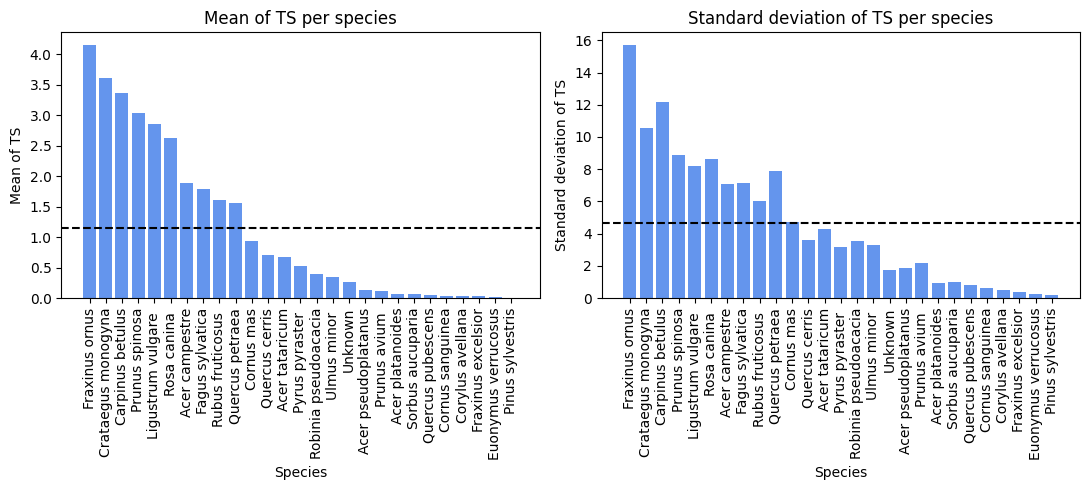

<Figure size 640x480 with 0 Axes>

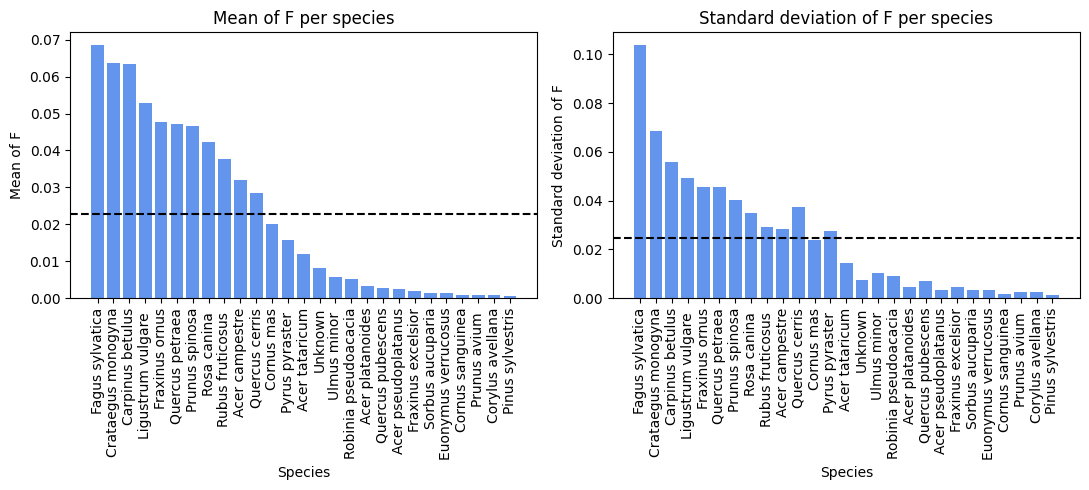

<Figure size 640x480 with 0 Axes>

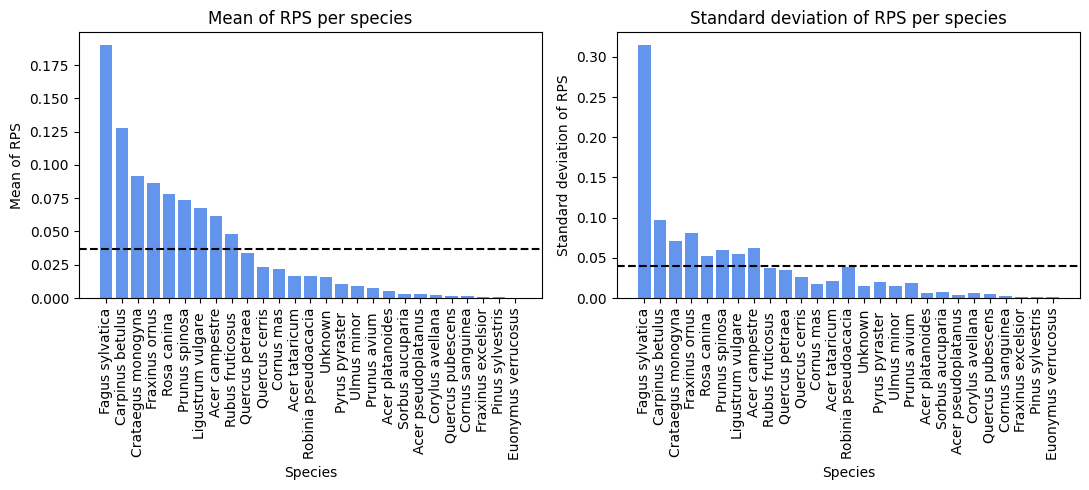

<Figure size 640x480 with 0 Axes>

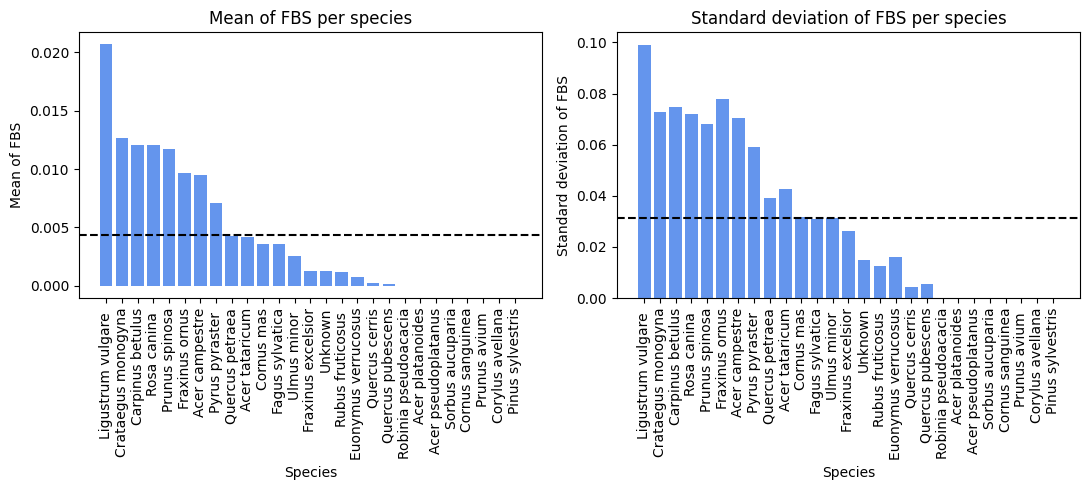

<Figure size 640x480 with 0 Axes>

In [40]:
features = [all_shoots, frequency, rps, agg_freshly_browsed]
feature_names = ['TS', 'F', 'RPS', 'FBS']

for i, feature in enumerate(features):

       meanDict = {key:value for key, value in \
                       sorted({key:value for key, value in zip(species, np.mean(feature[1:].astype(float), axis=0).tolist())}.items(), \
                              key=lambda item: item[1], reverse=True)}

       sdDict = {key : value for key, value in zip(species, \
              [np.abs(i) for i in np.std(feature[1:].astype(float), axis=0).tolist()])}

       #Ensuring that the two dictionaries are ordered identically.
       sdDict = {key : sdDict[key] for key in meanDict}

       labels1 = list(meanDict.keys())
       labels2 = list(sdDict.keys())
       values1 = list(meanDict.values())
       values2 = list(sdDict.values())

       bar_width = 0.35

       fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5))

       ax1.bar(labels1, values1, color='cornflowerblue')

       ax1.set_xlabel('Species')
       ax1.set_ylabel(f'Mean of {feature_names[i]}')
       ax1.set_title(f'Mean of {feature_names[i]} per species')
       ax1.set_xticklabels(labels1, rotation=90)

       ax1.axhline(y=np.mean(values1), color='black', linestyle='--')

       ax2.bar(labels2, values2, color='cornflowerblue')

       ax2.set_xlabel('Species')
       ax2.set_ylabel(f'Standard deviation of {feature_names[i]}')
       ax2.set_title(f'Standard deviation of {feature_names[i]} per species')
       ax2.set_xticklabels(labels2, rotation=90)

       ax2.axhline(y=np.mean(values2), color='black', linestyle='--')

       plt.tight_layout()

       plt.savefig(f'./Figures/mean_sd_{feature_names[i]}.png')

       plt.show()

       plt.clf()

## Creating constrained dataset

NOTE: this version of the dataset was not eventually used in the study as there was no apparent advantage for the performance of the ML models. 

In [12]:
rows_withoutSpecies = [i + 1 for i in np.where(np.all(all_shoots == 0, axis=1))[0].tolist()]

rows_withSpecies = [i for i in range(len(all_shoots)) if i not in rows_withoutSpecies]

agg_predictors_processed = agg_predictors[rows_withSpecies, :]
agg_freshly_browsed_processed = agg_freshly_browsed[rows_withSpecies, :]

print(f'Shape of processed predictors: {np.shape(agg_predictors_processed)}')
print(f'Shape of processed target variables: {np.shape(agg_freshly_browsed_processed)}')

Shape of processed predictors: (1645, 81)
Shape of processed target variables: (1645, 27)


In [13]:
np.savetxt('./Data/agg_predictors.csv', agg_predictors_processed, delimiter=',', fmt='%s')
np.savetxt('./Data/agg_freshly_browsed_dist.csv', agg_freshly_browsed_processed, delimiter=',', fmt='%s')